## Imports and downloads

In [ ]:
import pandas as pd
import numpy as np
import nltk

nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction import DictVectorizer
from sklearn .svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

from nltk.tokenize import word_tokenize


import matplotlib.pyplot as plt
import seaborn as sn

import lightgbm as lgbm
import pandas as pd
import sklearn
import sklearn.metrics
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from sklearn.preprocessing import StandardScaler, FunctionTransformer

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Load Data

In [ ]:
!ls

sample_data
SEM-2012-SharedTask-CD-SCO-test-cardboard.txt
SEM-2012-SharedTask-CD-SCO-test-circle.txt
SEM-2012-SharedTask-CD-SCO-training-simple.v2.txt


In [ ]:
from google.colab import files 
FILES_NOT_UPLOADED_YET = True
# Upload the Sem shared training and both testing datasets
if FILES_NOT_UPLOADED_YET:
    files.upload()

    # Training
    df_train = pd.read_table(
        'SEM-2012-SharedTask-CD-SCO-training-simple.v2.txt',header=None)

    # Dev
    df_test1 = pd.read_table('SEM-2012-SharedTask-CD-SCO-test-circle.txt', header=None)
    df_test2 = pd.read_table('SEM-2012-SharedTask-CD-SCO-test-cardboard.txt', header=None)
    df_test = pd.concat([df_test1, df_test2])

    def data_labeling(df):
        df.columns = ['Text','Sentence','Word_N','Word', 'Label']
        

    data_labeling(df_train)
    data_labeling(df_test)

Saving SEM-2012-SharedTask-CD-SCO-test-cardboard.txt to SEM-2012-SharedTask-CD-SCO-test-cardboard (1).txt
Saving SEM-2012-SharedTask-CD-SCO-test-circle.txt to SEM-2012-SharedTask-CD-SCO-test-circle (1).txt
Saving SEM-2012-SharedTask-CD-SCO-training-simple.v2.txt to SEM-2012-SharedTask-CD-SCO-training-simple.v2 (1).txt


## Tokenize

In [ ]:
def tokenize_custom(df):
    df["Token"] = df['Word'].apply(word_tokenize)
    df = df.explode("Token").reset_index(drop=True)
    return df

df_train = tokenize_custom(df_train)
df_test = tokenize_custom(df_test)

In [ ]:
df_train

,Text,Sentence,Word_N,Word,Label,Token
0,baskervilles01,0,0,Chapter,O,Chapter
1,baskervilles01,0,1,1.,O,1
2,baskervilles01,0,1,1.,O,.
3,baskervilles01,0,2,Mr.,O,Mr
4,baskervilles01,0,2,Mr.,O,.
...,...,...,...,...,...,...
65672,baskervilles14,270,58,slopes,O,slopes
65673,baskervilles14,270,59,of,O,of
65674,baskervilles14,270,60,the,O,the
65675,baskervilles14,270,61,moor,O,moor


## Lemmatization

In [ ]:
import nltk
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

# CURRENTLY WITHOUT POS (EVERYTHING IS NOUN)
df_train['Lemma'] = df_train['Token'].apply(lambda x: lemmatizer.lemmatize(x))
df_test['Lemma'] = df_test['Token'].apply(lambda x: lemmatizer.lemmatize(x))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
df_train

,Text,Sentence,Word_N,Word,Label,Token,Lemma
0,baskervilles01,0,0,Chapter,O,Chapter,Chapter
1,baskervilles01,0,1,1.,O,1,1
2,baskervilles01,0,1,1.,O,.,.
3,baskervilles01,0,2,Mr.,O,Mr,Mr
4,baskervilles01,0,2,Mr.,O,.,.
...,...,...,...,...,...,...,...
65672,baskervilles14,270,58,slopes,O,slopes,slope
65673,baskervilles14,270,59,of,O,of,of
65674,baskervilles14,270,60,the,O,the,the
65675,baskervilles14,270,61,moor,O,moor,moor


In [ ]:
df_test

,Text,Sentence,Word_N,Word,Label,Token,Lemma
0,circle01,0,0,``,O,``,``
1,circle01,0,1,Well,O,Well,Well
2,circle01,0,2,",",O,",",","
3,circle01,0,3,Mrs.,O,Mrs,Mrs
4,circle01,0,3,Mrs.,O,.,.
...,...,...,...,...,...,...,...
19268,cardboard,495,16,answer,O,answer,answer
19269,cardboard,495,17,as,O,as,a
19270,cardboard,495,18,ever,O,ever,ever
19271,cardboard,495,19,.,O,.,.


## Represent token features as training and dev instances

In [ ]:
train_instances = df_train[['Token', 'Lemma']].to_dict('records')
test_instances = df_test[['Token', 'Lemma']].to_dict('records')

train_instances[0:20]

[{'Lemma': 'Chapter', 'Token': 'Chapter'},
 {'Lemma': '1', 'Token': '1'},
 {'Lemma': '.', 'Token': '.'},
 {'Lemma': 'Mr', 'Token': 'Mr'},
 {'Lemma': '.', 'Token': '.'},
 {'Lemma': 'Sherlock', 'Token': 'Sherlock'},
 {'Lemma': 'Holmes', 'Token': 'Holmes'},
 {'Lemma': 'Mr', 'Token': 'Mr'},
 {'Lemma': '.', 'Token': '.'},
 {'Lemma': 'Sherlock', 'Token': 'Sherlock'},
 {'Lemma': 'Holmes', 'Token': 'Holmes'},
 {'Lemma': ',', 'Token': ','},
 {'Lemma': 'who', 'Token': 'who'},
 {'Lemma': 'wa', 'Token': 'was'},
 {'Lemma': 'usually', 'Token': 'usually'},
 {'Lemma': 'very', 'Token': 'very'},
 {'Lemma': 'late', 'Token': 'late'},
 {'Lemma': 'in', 'Token': 'in'},
 {'Lemma': 'the', 'Token': 'the'},
 {'Lemma': 'morning', 'Token': 'mornings'}]

## Vectorizing features

In [ ]:
vec = DictVectorizer()

x_train = vec.fit_transform(train_instances)
x_train.shape

x_test = vec.transform(test_instances)

In [ ]:
x_train.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
print(vec.get_feature_names_out()[0:12])

['Lemma=!' "Lemma='" "Lemma=''" "Lemma='66" "Lemma='d" "Lemma='ll"
 "Lemma='m" "Lemma='re" "Lemma='s" "Lemma='ve" 'Lemma=(' 'Lemma=)']


In [ ]:
y_train = df_train.Label.to_list()
y_test = df_test.Label.to_list()


# **SVM**

In [ ]:
# WITHOUT PARAMETER OPTIMIZATION:
classifier = LinearSVC()
classifier.fit(x_train, y_train)
predictions = classifier.predict(x_test)
df_test['SVM_not_optimised'] = predictions
clsf_report = pd.DataFrame(classification_report(y_true = df_test['Label'], y_pred = df_test['SVM_not_optimised'], output_dict = True)).transpose() 
clsf_report

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
B-NEG,0.893238,0.933086,0.912727,269.000000
I-NEG,0.000000,0.000000,0.000000,5.000000
O,0.998842,0.998474,0.998658,18999.000000
accuracy,0.997302,0.997302,0.997302,0.997302
macro avg,0.630693,0.643853,0.637128,19273.000000
weighted avg,0.997109,0.997302,0.997199,19273.000000


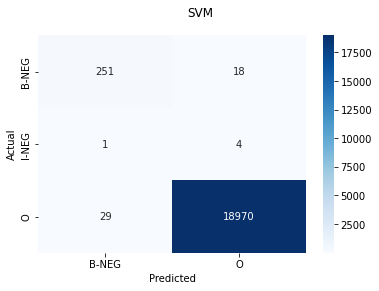

In [ ]:
confusion_matrix = pd.crosstab(df_test['Label'], df_test['SVM_not_optimised'], rownames=['Actual'], colnames = ['Predicted'])
sn.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g')
plt.suptitle('SVM')
plt.show()

In [ ]:
## WITH PARAMETER OPTIMIZATION:
classifier = LinearSVC()

parameters = dict(
    C = (0.0001, 0.001, 0.01, 0.1, 1.0),
    loss = ('hinge', 'squared_hinge'),
    tol = (1e-08, 1e-07, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1)
)

grid = GridSearchCV(estimator = classifier, param_grid = parameters, cv = 5, scoring = 'f1_macro')

# from sklearn.svm import SVC
# classifier = SVC()
# parameters = {'C':[0.1,1,100,1000],'kernel':['rbf','poly','sigmoid','linear'],'degree':[1,2,3,4,5,6],'gamma': [1, 0.1, 0.01, 0.001, 0.0001]}
# grid = GridSearchCV(estimator = classifier, param_grid = parameters, cv = 5, scoring = 'f1_macro')

grid.fit(x_train, y_train)
classifier = grid.best_estimator_
print("Best parameters:", grid.best_params_)
predictions = classifier.predict(x_test)
df_test['SVM'] = predictions
clsf_report = pd.DataFrame(classification_report(y_true = df_test['Label'], y_pred = df_test['SVM'], output_dict = True)).transpose()
clsf_report

Best parameters: {'C': 1.0, 'loss': 'hinge', 'tol': 1e-08}


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
B-NEG,0.893238,0.933086,0.912727,269.000000
I-NEG,0.000000,0.000000,0.000000,5.000000
O,0.998842,0.998474,0.998658,18999.000000
accuracy,0.997302,0.997302,0.997302,0.997302
macro avg,0.630693,0.643853,0.637128,19273.000000
weighted avg,0.997109,0.997302,0.997199,19273.000000


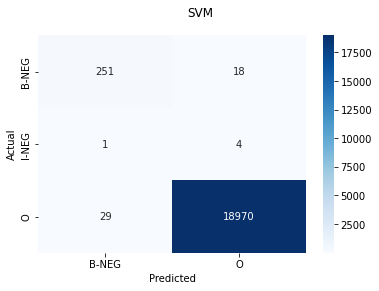

In [ ]:
confusion_matrix = pd.crosstab(df_test['Label'], df_test['SVM'], rownames=['Actual'], colnames = ['Predicted'])
map = sn.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g')
plt.suptitle('SVM')
plt.show()
from pylab import savefig
figure = map.get_figure()
figure.savefig('conf_matrix_baseline.pdf')

# **LightGBM (extra, not our baseline model)**

In [ ]:
clf_params = {
    'classifier__num_leaves':         sp_randint(7, 2095), 
    'classifier__min_child_samples':  sp_randint(5, 500), 
    'classifier__min_child_weight':   [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
    'classifier__subsample':          sp_uniform(loc=0.2, scale=0.8), 
    'classifier__scale_pos_weight':   sp_randint(1, 10000),
    'classifier__colsample_bytree':   sp_uniform(loc=0.4, scale=0.6),
    'classifier__reg_alpha':          [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
    'classifier__reg_lambda':         [0, 1e-1, 1, 5, 10, 20, 50, 100],
    'classifier__max_depth':          sp_randint(2, 50), # was 2,63 but saw max used is ~47
    'classifier__objective':          ['cross_entropy', 'softmax'],
    'classifier__bagging_freq':       [1]
}

In [ ]:
clf = Pipeline(
    steps=[
            ('classifier',  lgbm.LGBMClassifier())
        ]
    )

rscv = RandomizedSearchCV(
    clf,
    param_distributions = clf_params,
    n_iter = 10,
    cv = 5, # 80% train 20% val
    verbose = 2,
    n_jobs = 2
)

rscv.fit(x_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('classifier', LGBMClassifier())]),
                   n_jobs=2,
                   param_distributions={'classifier__bagging_freq': [1],
                                        'classifier__colsample_bytree': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f8fe3c40a90>,
                                        'classifier__max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f8fe3c40ad0>,
                                        'classifier__m...
                                        'classifier__objective': ['cross_entropy',
                                                                  'softmax'],
                                        'classifier__reg_alpha': [0, 0.1, 1, 2,
                                                                  5, 7, 10, 50,
                                                                  100],
                                        'classifier__reg_lam

## Test model on test set

In [ ]:
classifier_LGB = rscv.best_estimator_
predictions_LGB = classifier_LGB.predict(x_test)

## Results

In [ ]:
df_test['LGB'] = predictions_LGB
clsf_report_LGB = pd.DataFrame(classification_report(y_true = df_test['Label'], y_pred = df_test['LGB'], output_dict = True)).transpose()
clsf_report_LGB

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
B-NEG,0.897727,0.293680,0.442577,269.000000
I-NEG,0.000000,0.000000,0.000000,5.000000
O,0.989836,0.999526,0.994657,18999.000000
accuracy,0.989415,0.989415,0.989415,0.989415
macro avg,0.629188,0.431069,0.479078,19273.000000
weighted avg,0.988293,0.989415,0.986694,19273.000000


## Confusion matrix

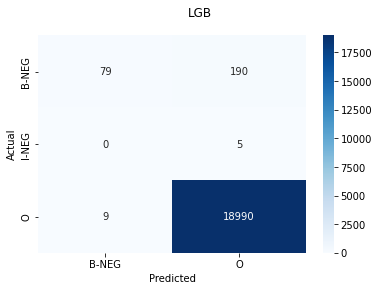

In [ ]:
confusion_matrix_LGB = pd.crosstab(df_test['Label'], df_test['LGB'], rownames=['Actual'], colnames = ['Predicted'])
sn.heatmap(confusion_matrix_LGB, annot=True, cmap='Blues', fmt='g')
plt.suptitle('LGB')
plt.show()